In [1]:
library(corrplot)
library(tidyverse)
library(caret)
library(repr)
library(fastDummies)
library(gridExtra)
library(e1071)

corrplot 0.84 loaded
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift


Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



# Which Factors Effectively Predict the Presence of Chronic Kidney Disease?

## Introduction
Chronic Kidney Disease (CKD) is characterized by a prolonged period of markedly reduced kidney function. If left unresolved, CKD can lead to a bevy of serious health conditions, including kidney failure (Levey et al. 2007). Globally, the presence of CKD is on the rise. As a result, CKD is considered a rapidly growing global health concern, from which public healthcare systems incur significant cost (Levey et al. 2003). Fortunately, evidence exists suggesting that early detection and treatment of CKD can help mitigate the physiological toll that it takes on the body (Levey et al. 2003). Numerous health conditions have been associated with CKD onset including diabetes and hypertension, and multiple physiological measures can be used to assay kidney function (Levey et al. 2003). With this in mind, it may be possible to predict a patient's diagnosis based on common biological markers of renal health. The University College London Machine Learning (UCL ML) group has compiled a dataset of 400 observations across 25 variables related to kidney health, with each observation given a CKD diagnosis. This study attempts to determine whether its possible to train a k-nn classification model to accurately predict a patient's CKD diagnosis using the health measures included in the UCL ML CKD dataset, and if so, which variables are most effective for making these predictions.

## Methods and Results

### Wrangling

#### Load in the Dataset
First we need to read in the dataset. The dataset is given in a standard CSV file format. We can read this in using the `read_csv`. The data has been saved locally, so we only need to specify a relative path.

In [2]:
ckd <- read_csv("data/chronic_kidney_disease_full.csv")
head(ckd)

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_integer(),
  bp = col_integer(),
  sg = col_double(),
  al = col_integer(),
  su = col_integer(),
  bgr = col_integer(),
  bu = col_double(),
  sc = col_double(),
  sod = col_double(),
  pot = col_double(),
  hemo = col_double(),
  pcv = col_integer(),
  wbcc = col_double(),
  rbcc = col_double()
)
See spec(...) for full column specifications.


age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
48,80,1.020,1,0,NA,normal,notpresent,notpresent,121,⋯,44,7800,5.2,yes,yes,no,good,no,no,ckd
7,50,1.020,4,0,NA,normal,notpresent,notpresent,NA,⋯,38,6000,NA,no,no,no,good,no,no,ckd
62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,⋯,31,7500,NA,no,yes,no,poor,no,yes,ckd
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,⋯,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,⋯,35,7300,4.6,no,no,no,good,no,no,ckd
60,90,1.015,3,0,NA,NA,notpresent,notpresent,74,⋯,39,7800,4.4,yes,yes,no,good,yes,no,ckd


**Table 1**: Head of the UCL ML CKD dataset in its unaltered form

#### Converting Categories to Factors

This dataset contains many categorical variables. So here we're going to convert them to factors, and express these factors using their numeric representation (as assigned by R). First we create a vector of column names containing all the columns that need to be expressed as numeric factors. Then we iterate through each of these columns, converting them to the numeric representation of their factors. 

In [3]:
categorical_b <- c('pcc', 'rbc', 'pc', 'ba', 'dm', 'htn', 'cad', 'appet', 'pe', 'ane', 'class')
categorical_m <- c('sg', 'al', 'su')

for (cat in categorical_b) {
    ckd[cat] <- ckd %>%
        select(cat) %>%
        unlist() %>%
        as.factor() %>%
        as.numeric()
}

head(ckd)


#############
# Some Notes
#############
# 1 = no, 2 = yes
# 1 = abnormal, 2 = normal
# 1 = notpresent, 2 = present
# 1 = good, 2 = poor
# 1 = cdk, 2 = nockd

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
48,80,1.020,1,0,NA,2,1,1,121,⋯,44,7800,5.2,2,2,1,1,1,1,1
7,50,1.020,4,0,NA,2,1,1,NA,⋯,38,6000,NA,1,1,1,1,1,1,1
62,80,1.010,2,3,2,2,1,1,423,⋯,31,7500,NA,1,2,1,2,1,2,1
48,70,1.005,4,0,2,1,2,1,117,⋯,32,6700,3.9,2,1,1,2,2,2,1
51,80,1.010,2,0,2,2,1,1,106,⋯,35,7300,4.6,1,1,1,1,1,1,1
60,90,1.015,3,0,NA,NA,1,1,74,⋯,39,7800,4.4,2,2,1,1,2,1,1


**Table 2**: CKD dataset following conversion of categories to factors

#### Scaling Continuous Variables
The magnitude of the continuous variables in the CKD dataset vary greatly. This would impact the performance of k-nn classification, because variables of very large magnitudes would contribute disproportionately towards model predictions. To mitigate this, the following code will scale each of the continuous variables to lie between 0 and 1. The result of this execution will be saved to a new dataframe `ckd_scaled`.

In [4]:
################################
# Specify the columns as vector
################################
ckd_scaled <- ckd
continuous <- c('age', 'bp', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc')

#################
# Define Function
#################
# SOURCE: Stack overflow
range01 <- function(x, ...){(x - min(x, ...)) / (max(x, ...) - min(x, ...))}


# Convert to factors
for (con in continuous) {
    ckd_scaled[con] <- range01(ckd_scaled[con], na.rm = TRUE)
}

head(ckd_scaled)

age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,⋯,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0.52272727,0.2307692,1.020,1,0,NA,2,1,1,0.2115385,⋯,0.7777778,0.2314050,0.5254237,2,2,1,1,1,1,1
0.05681818,0.0000000,1.020,4,0,NA,2,1,1,NA,⋯,0.6444444,0.1570248,NA,1,1,1,1,1,1,1
0.68181818,0.2307692,1.010,2,3,2,2,1,1,0.8568376,⋯,0.4888889,0.2190083,NA,1,2,1,2,1,2,1
0.52272727,0.1538462,1.005,4,0,2,1,2,1,0.2029915,⋯,0.5111111,0.1859504,0.3050847,2,1,1,2,2,2,1
0.55681818,0.2307692,1.010,2,0,2,2,1,1,0.1794872,⋯,0.5777778,0.2107438,0.4237288,1,1,1,1,1,1,1
0.65909091,0.3076923,1.015,3,0,NA,NA,1,1,0.1111111,⋯,0.6666667,0.2314050,0.3898305,2,2,1,1,2,1,1


**Table 3**: CKD dataset following scaling of continuous variables

##### Proportion of NA Observations
---
After calling head() on the dataset, it became apparent that many of the observations have one or more NA columns. The proportion of observations that were NA by column was printed to indicate how significant the problem of missing values was, and to guide how they should be handled.

In [5]:
prop_of_na_rows <-  sapply(ckd, function(y) sum(length(which(is.na(y))))/nrow(ckd))
prop_of_na_rows <-  data.frame(Proportion=prop_of_na_rows)
prop_of_na_rows

,Proportion
age,0.0225
bp,0.0300
sg,0.1175
al,0.1150
su,0.1225
rbc,0.3800
pc,0.1625
pcc,0.0100
ba,0.0100
bgr,0.1100


**Table 4**: Proportion of observations that are missing by variable

#### All Columns Need a Class
---
At a minimum, any observation thats included in our analysis will have to have a classification (CKD/No CKD). There were three observations without a class, these rows were dropped.

In [6]:
# Drop NA rows of class
ckd_scaled <- ckd_scaled %>%
    filter(!is.na(class))

# We expect this to be true. Fail otherwise
stopifnot(nrow(ckd) == 400)
stopifnot(nrow(ckd_scaled) == 397)

#### Dealing with Missing Values (NAs)
Because many of the variables had high proportions of missing values (table ), dropping the rows was not feasible. As an alternative, the following approach for handling missing values was taken:
- Replace <strong>continuous numeric variables</strong> with the <strong>mean</strong> average for that column and row-specific disease class
- Replace <strong>categorical/nominal variables</strong> with the <strong>mode</strong> average for that column and row-specific disease class

The dataset was split by class label. Following the split, the necessary replacements were performed using the class-specific mean/mode. The datasets were then merged back into a new, single data frame, `ckd_scaled_na_replaced`. A check was then performed to verify the cleaned dataset was free of missing values.

In [7]:
#########################
# Defining our functions
########################
### Define Mean
impute.mean <- function(x) replace(x = x, list = is.na(x), values = mean(x, na.rm = TRUE))
### Define Mode
Mode <- function(x) {
    x <- x[!is.na(x)]
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

impute.mode <- function(x) replace(x = x, list = is.na(x), values = Mode(x))


########################
# Splitting dataframes
########################
ckd_average <- ckd_scaled %>% 
    filter(class == 1)
not_ckd_average <- ckd_scaled  %>% 
    filter(class == 2)

##########################
# Replacing NA's of ckd df
##########################
for (con in continuous) {
    ckd_average[con] <- impute.mean(unlist(ckd_average[con]))
}
for (cat in categorical_b) {
    ckd_average[cat] <- impute.mode(unlist(ckd_average[cat]))
}

for (lab in categorical_m) {
    ckd_average[lab] <- impute.mode(unlist(ckd_average[lab]))
}

##############################
# Replacing NA's of non-ckd df
##############################
for (con in continuous) {
    not_ckd_average[con] <- impute.mean(unlist(not_ckd_average[con]))
}

for (cat in categorical_b) {
    not_ckd_average[cat] <- impute.mode(unlist(not_ckd_average[cat]))
}

for (lab in categorical_m) {
    not_ckd_average[lab] <- impute.mode(unlist(not_ckd_average[lab]))
}

######################
# Perform row bind
######################
ckd_scaled_na_replaced <- bind_rows(ckd_average, not_ckd_average)
proportion_of_na_obs <- sapply(ckd_scaled_na_replaced, function(y) sum(length(which(is.na(y))))/nrow(ckd_scaled))
ckd_scaled_na_replaced_nrow <- nrow(ckd_scaled_na_replaced)
       
# We expect this to be true. Fail otherwise
stopifnot(ckd_scaled_na_replaced_nrow == 397) 
for (row in proportion_of_na_obs) {
    stopifnot(row == 0)
}

#### Creating Dummy Variables
There are three nominal variables in the dataset: 
- <strong>al</strong>: Albumin
- <strong>sg</strong>: Specific Gravity (Fluid weight)
- <strong>su</strong>: Blood Sugar

These three variables each have 6 distinct levels, which can be difficult to work with. To correct these, we created dummy variables for each level of the nominal variables. To do this, we used `fastDummies::dummy_cols`. Each dummy variable is given its own column. These new columns were then merged into the dataset as a new dataframe: `ckd_scaled_na_replaced_d`. Lastly, we checked that they were succesfully created and merged, without introducing any new NA observations. This represents the cleaned dataset that will be used throughout our analysis.

In [8]:
########################
# Create dummy variables
########################

ckd_scaled_na_replaced_d <- dummy_cols(ckd_scaled_na_replaced, select_columns=c("al",'sg','su'))
ckd_scaled_na_replaced_d <- ckd_scaled_na_replaced_d %>% 
    select(-sg,-al,-su)
head(ckd_scaled_na_replaced_d)
ckd_scaled_na_replaced_d_cols <- colnames(ckd_scaled_na_replaced_d)

# We expect this to be true. Fail otherwise
stopifnot(is.element('al_1',ckd_scaled_na_replaced_d_cols),is.element('sg_1.01',ckd_scaled_na_replaced_d_cols))
stopifnot(is.element('su_0',ckd_scaled_na_replaced_d_cols))

# Check for NAs again
list_of_var_nas <- sapply(ckd_scaled_na_replaced_d, function(y) sum(length(which(is.na(y))))/nrow(ckd_scaled))
for (var in list_of_var_nas) {
    stopifnot(row == 0)
}

age,bp,rbc,pc,pcc,ba,bgr,bu,sc,sod,⋯,sg_1.01,sg_1.005,sg_1.015,sg_1.025,su_0,su_3,su_4,su_1,su_2,su_5
0.52272727,0.2307692,2,2,1,1,0.2115385,0.08857510,0.010582011,0.8162936,⋯,0,0,0,0,1,0,0,0,0,0
0.05681818,0.0000000,2,2,1,1,0.3280423,0.04236200,0.005291005,0.8162936,⋯,0,0,0,0,1,0,0,0,0,0
0.68181818,0.2307692,2,2,1,1,0.8568376,0.13222080,0.018518519,0.8162936,⋯,1,0,0,0,0,1,0,0,0,0
0.52272727,0.1538462,2,1,2,1,0.2029915,0.13992298,0.044973545,0.6719243,⋯,0,1,0,0,1,0,0,0,0,0
0.55681818,0.2307692,2,2,1,1,0.1794872,0.06290116,0.013227513,0.8162936,⋯,1,0,0,0,1,0,0,0,0,0
0.65909091,0.3076923,2,2,1,1,0.1111111,0.06033376,0.009259259,0.8675079,⋯,0,0,1,0,1,0,0,0,0,0


**Table 5**: CKD dataset with all NA and dummy variables replaced (as described above)

### Exploratory Analysis

#### Summary Statistics
---
Included below is a summary of the cleaned dataset.

In [9]:
## Call with vector of data, number of rows, and the comparitor to increment on
calcMode <- function (x) {
    x <- x[!is.na(x)]
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

# Summary for the data set with all NAs filled
ckd_scaled_na_replace_d_summary <- ckd_scaled_na_replaced_d %>% 
    group_by(class) %>% 
    summarize(Count = n(), mean.age=mean(age,na.rm=TRUE), mean.bp = mean(bp, na.rm = TRUE), 
             mean.bgr = mean(bgr, na.rm = TRUE), mean.bu = mean(bu, na.rm = TRUE), mean.sc = mean(sc, na.rm = TRUE),
             mean.sod = mean(sod, na.rm = TRUE), mean.pot = mean(pot, na.rm = TRUE), mean.hemo = mean(hemo, na.rm=TRUE),
             mean.pcv = mean(pcv, na.rm = TRUE), mean.wbcc = mean(wbcc, na.rm = TRUE), mean.rbcc = mean(rbcc, na.rm = TRUE),
             mode.pcc = calcMode(pcc), mode.rbc = calcMode(rbc), mode.pc = calcMode(pc),
             mode.ba = calcMode(ba), mode.dm = calcMode(dm), mode.htn = calcMode(htn),
             mode.cad = calcMode(cad), mode.appet = calcMode(appet), mode.pe = calcMode(pe),
             mode.ane = calcMode(ane), mode.sg.101 = calcMode(sg_1.01), 
             mode.sg.1005=calcMode(sg_1.005), mode.sg.1015=calcMode(sg_1.015),
             mode.sg.1025=calcMode(sg_1.025), mode.su.0=calcMode(su_0), mode.su.1=calcMode(su_1),
             mode.su.2=calcMode(su_2),mode.su.3=calcMode(su_3),mode.su.4=calcMode(su_4),
             mode.su.5=calcMode(su_5),mode.al.0=calcMode(al_0),mode.al.1=calcMode(al_1),
             mode.al.2=calcMode(al_2), mode.al.3=calcMode(al_3), mode.al.4=calcMode(al_4),
             mode.al.5=calcMode(al_5))

print("CKD Scaled Summary")
head(ckd_scaled_na_replace_d_summary)
# Uncomment this line to save a copy of the summary to view in a spreadsheet editor
# write_csv(ckd_scaled_na_replace_d_summary, "./summary.csv")

[1] "CKD Scaled Summary"


class,Count,mean.age,mean.bp,mean.bgr,mean.bu,mean.sc,mean.sod,mean.pot,mean.hemo,⋯,mode.su.2,mode.su.3,mode.su.4,mode.su.5,mode.al.0,mode.al.1,mode.al.2,mode.al.3,mode.al.4,mode.al.5
1,248,0.5957386,0.2285068,0.3280423,0.18268593,0.053316407,0.8162936,0.05355124,0.5137562,⋯,0,0,0,0,0,0,0,0,0,0
2,149,0.5036855,0.1643119,0.1831779,0.08008295,0.006209583,0.8657115,0.04143258,0.8230817,⋯,0,0,0,0,1,0,0,0,0,0


**Table 6**: Summary statistics for the cleaned CKD dataset. Continuous variables are reported as a mean average, and categorical/nominal variables reported as a mode average.

#### Histograms of Numeric Values by Disease Class
For the continuous variables in the dataset, we will create histograms and scatterplots of the data to try to elucidate which variables may be important for predicting Chronic Kidney Disease. For each numeric variable, a histrogram will be created, stratified by disease class to determine if there are any distinct differences in these measurements for the two disease status groups.
The numeric variables that will be visualized using histograms are:
- Age
- Blood Pressure (bp)
- Blood Glucose Random (bgr)
- Blood Urea (bu)
- Serum Creatinine (sc)
- Sodium (sod)
- Potassium (pot)
- hemoglobin (hemo)
- Packed Cell Volume (pcv)
- White Blood Cell Count (wbcc)
- Red Blood Cell Count (rbcc)



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


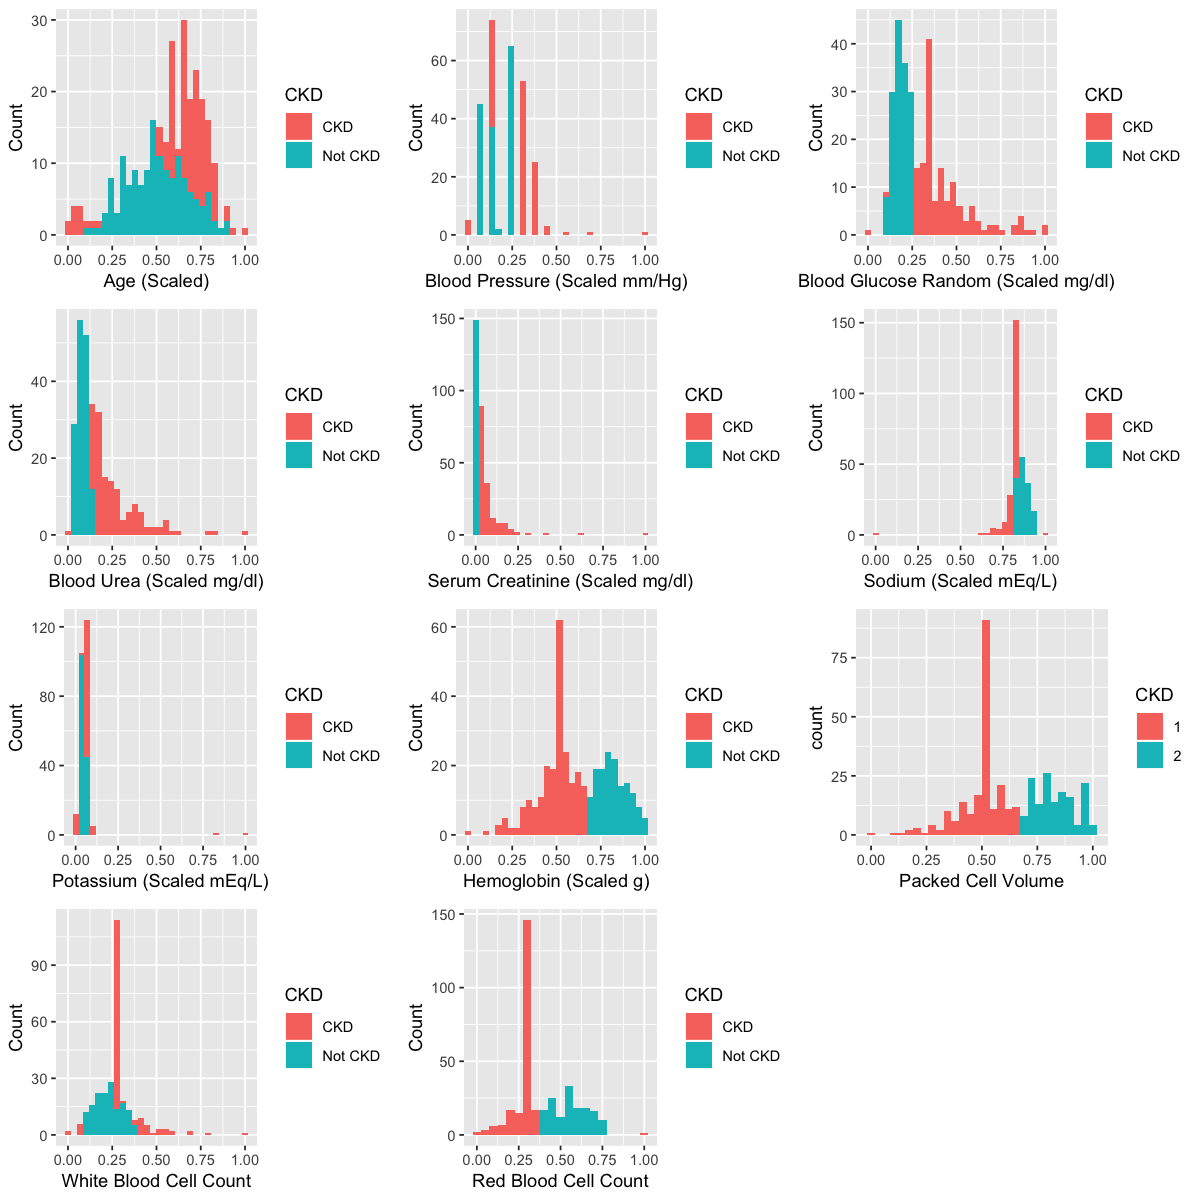

In [10]:
options(repr.plot.width=10, repr.plot.height=10)
# Choose the dataset here!
workingData <- ckd_scaled_na_replaced_d
# workingData <- ckd_low_na
# workingData <- ckd_no_na

#############
# Some Notes
#############
# 1 = no, 2 = yes
# 1 = abnormal, 2 = normal
# 1 = notpresent, 2 = present
# 1 = good, 2 = poor
# 1 = cdk, 2 = nockd

# Hist Age
ageHist <- ggplot(workingData, aes(x=age, fill = factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    labs(fill='CKD')+
    xlab("Age (Scaled)") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Blood Pressure
bloodPressureHist <- ggplot(workingData, aes(x=bp, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Blood Pressure (Scaled mm/Hg)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Blood Glucose Random
bloodGlucRandomHist <- ggplot(workingData, aes(x=bgr, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Blood Glucose Random (Scaled mg/dl)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Urea
bloodUreaHist <- ggplot(workingData, aes(x=bu, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Blood Urea (Scaled mg/dl)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Serum Creatinine
serumCreatinineHist <- ggplot(workingData, aes(x=sc, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Serum Creatinine (Scaled mg/dl)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Sodium
sodiumHist <- ggplot(workingData, aes(x=sod, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Sodium (Scaled mEq/L)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Potassium
potHist <- ggplot(workingData, aes(x=pot, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Potassium (Scaled mEq/L)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Hemoglobin
hemoglobinHist <- ggplot(workingData, aes(x=hemo, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Hemoglobin (Scaled g)") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Packed Cell Volume
packedCellVolumeHist <- ggplot(workingData, aes(x=pcv, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("Packed Cell Volume") +
    labs(fill="CKD")
# Hist White Blood Cell Count
wbcHist <- ggplot(workingData, aes(x=wbcc, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity") + 
    xlab("White Blood Cell Count") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Hist Red Blood Cell Count
rbcHist <- ggplot(workingData, aes(x=rbcc, fill=factor(class))) + 
    geom_histogram(alpha=1, pos="identity", binwidth=0.05) + 
    xlab("Red Blood Cell Count") +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    ylab("Count")
# Arrange the plots onto the screen
grid.arrange(ageHist, bloodPressureHist, bloodGlucRandomHist, bloodUreaHist,
             serumCreatinineHist, sodiumHist, potHist, hemoglobinHist, packedCellVolumeHist, wbcHist, rbcHist, nrow=4)


**Figure 1**: Histograms of all continuous variables in the dataset, stratified by disease status.

#### Conclusions
Looking at the above histograms, the distributions for the variables: **Hemoglobin**, **Packed Cell Volume**, and **Red Blood Cell Count**, dramatically differ between disease and non-disease patients. These variables may therefore be more predictive in the k-nn model, relative to the other variables available in the dataset.

#### Plots of Categorical Variables by Disease Status
---
For the categorical variables, differences in distributions by disease status were visualized by converting the categorical variables to counts. These counts were then plotted as proportions startified by disease status. For readability, categories with the most non-CKD observations were plotted closest to the origin. The following categorical variables were visualized:

- Pus Cell Clumps (pcc)
- Red Blood Cells (rbc)
- Pus Cell (pc)
- Bacteria (ba)
- Diabetes Mellitus (dm)
- Hypertension (htn)
- Coronary Artery Disease (cad)
- Appetite (appet)
- Pedal Edema (pe)
- Anemia (ane)


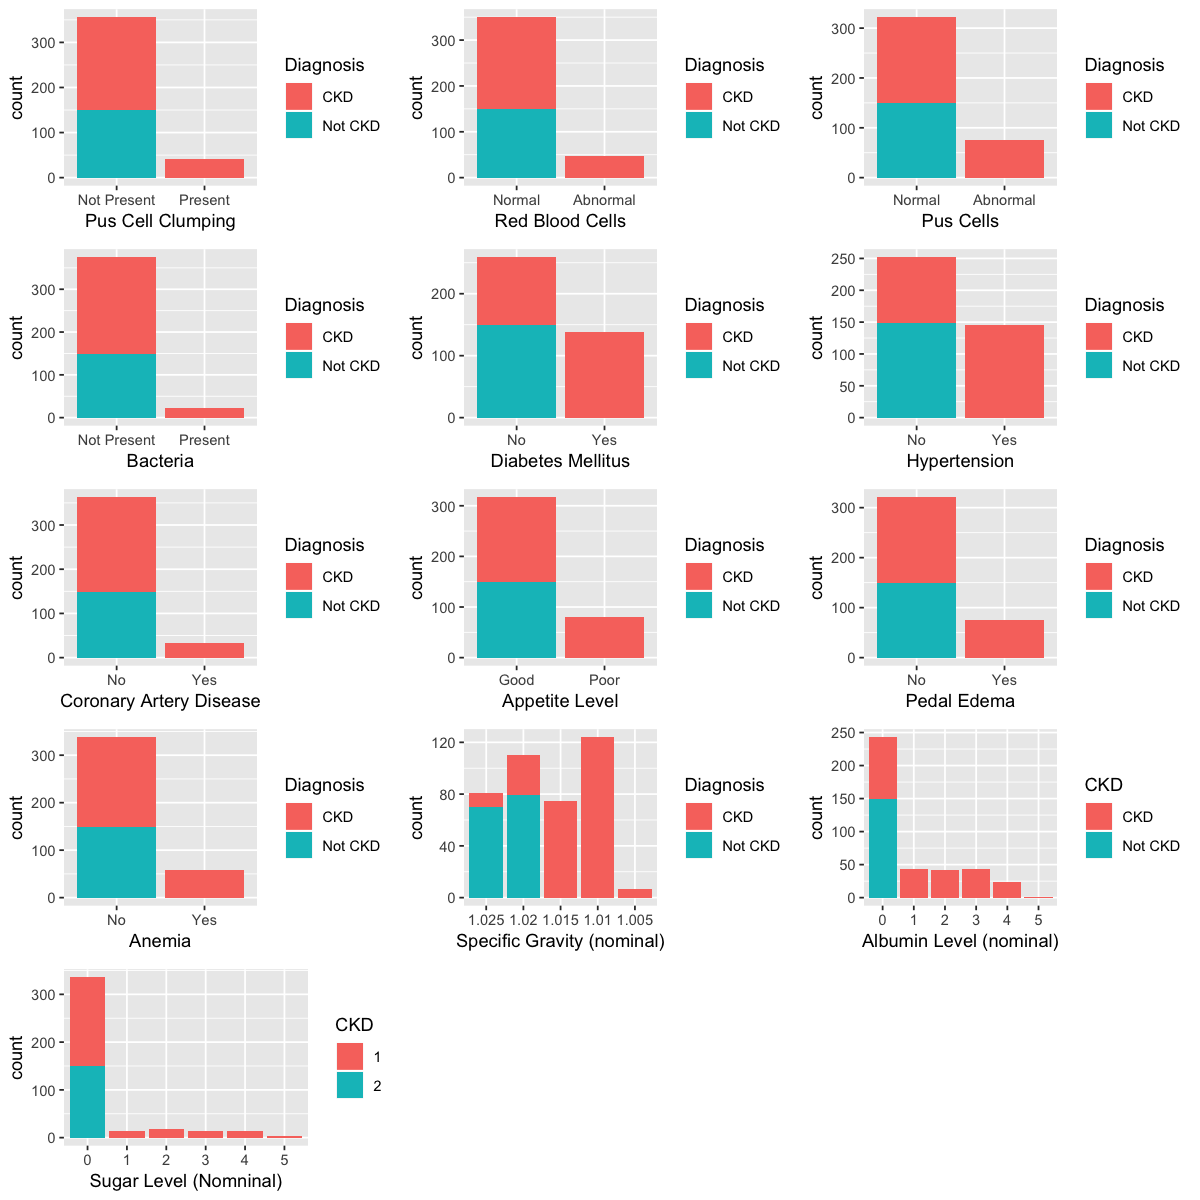

In [11]:
workingData <- ckd_scaled_na_replaced_d;
# workingData <- ckd_no_na;
# workingData <- ckd_low_na;
options(repr.plot.width=10, repr.plot.height=10)

#############
# Some Notes
#############
# 1 = no, 2 = yes
# 1 = abnormal, 2 = normal
# 1 = notpresent, 2 = present
# 1 = good, 2 = poor
# 1 = cdk, 2 = nockd

# Plot Pus Cell Clumping 
pccPlot <- ggplot(workingData, aes(factor(pcc),fill=factor(class))) + 
    geom_bar() +
    labs(fill="Diagnosis") +
    scale_x_discrete(labels=c("1" = "Not Present", "2" = "Present")) +
    xlab("Pus Cell Clumping") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Red Blood Cell
rbcPlot <- ggplot(workingData, aes(factor(rbc),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(limits=c("2","1"),labels=c("1" = "Abnormal", "2" = "Normal")) +
    xlab("Red Blood Cells") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Pus Cell
pcPlot <- ggplot(workingData, aes(factor(pc),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(limits=c("2","1"),labels=c("1" = "Abnormal", "2" = "Normal")) + 
    xlab("Pus Cells") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Bacteria
bacteriaPlot <- ggplot(workingData, aes(factor(ba),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") +
    scale_x_discrete(labels=c("1" = "Not Present", "2" = "Present")) +
    xlab('Bacteria') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
diabetesPlot <- ggplot(workingData, aes(factor(dm),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "No", "2" = "Yes")) +
    xlab('Diabetes Mellitus') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Hypertension 
hypertensionPlot <- ggplot(workingData, aes(factor(htn),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "No", "2" = "Yes"))+
    xlab('Hypertension') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Coronary Artery Disease
cadPlot <- ggplot(workingData, aes(factor(cad),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "No", "2" = "Yes")) +
    xlab('Coronary Artery Disease') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Appetite
appetitePlot <- ggplot(workingData, aes(factor(appet),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "Good", "2" = "Poor")) +
    xlab('Appetite Level') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Edema
edemaPlot <- ggplot(workingData, aes(factor(pe),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "No", "2" = "Yes")) +
    xlab('Pedal Edema') + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Anemia
anemiaPlot <- ggplot(workingData, aes(factor(ane),fill=factor(class))) + 
    geom_bar() + 
    labs(fill="Diagnosis") + 
    scale_x_discrete(labels=c("1" = "No", "2" = "Yes")) + 
    xlab("Anemia") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD"))
# Plot Specific Gravity (Nominal)
sgPlot <- ggplot(ckd_scaled_na_replaced, aes(factor(sg),fill=factor(class))) +
    geom_bar() +
    labs(fill="Diagnosis") +
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    xlab("Specific Gravity (nominal)") +
    scale_x_discrete(limits=c("1.025","1.02","1.015","1.01","1.005"))
# Plot Albumin (Nominal)
alPlot <- ggplot(ckd_scaled_na_replaced, aes(factor(al),fill=factor(class))) +
    geom_bar() +
    labs(fill="CKD") + 
    scale_fill_discrete(labels=c("1" = "CKD", "2" = "Not CKD")) + 
    xlab("Albumin Level (nominal)")
# Plot Sugar (Nominal)
suPlot <- ggplot(ckd_scaled_na_replaced, aes(factor(su), fill=factor(class)))+
    geom_bar()+
    labs(fill="CKD")+
    xlab("Sugar Level (Nomninal)")
# Arrange the plots for display
grid.arrange(pccPlot, rbcPlot, pcPlot, bacteriaPlot, diabetesPlot,
             hypertensionPlot, cadPlot, appetitePlot, edemaPlot, anemiaPlot, sgPlot, alPlot, suPlot, nrow=5)

**Figure 2**: Plots of all categorical and nominal variables stratified by disease class.

#### Conclusions
---
**Diabetes mellitus**, **Hypertension**, **Albumin**, and **Specific Gravity** all show a marked divide in the number of CKD patients in one category, relative to the other. For the other variables, there is less of a deviation between the disease classes, or one category has very few observations overall. Considering such, the listed variables are expected to have strong predictive power in a k-nn classification model.

#### Correlation Matrix
---
A correlation matrix was made to visualize which variables best align with disease class. corrplot::cor was used to create the plot. An arbitrary correlation coefficient of $\sim \pm0.5$, was used as a cutoff for deciding whether a variable was considered strongly correlated with disease status. In agreement with the results in Figures 1 and 2, **Specific Gravity**, **Hypertension**, **Diabetes mellitus**, **Hemoglobin**, **Packed Cell Volume**, **Red Blood Cell Count**, and **Albumin** seem to correlate well with disease class.

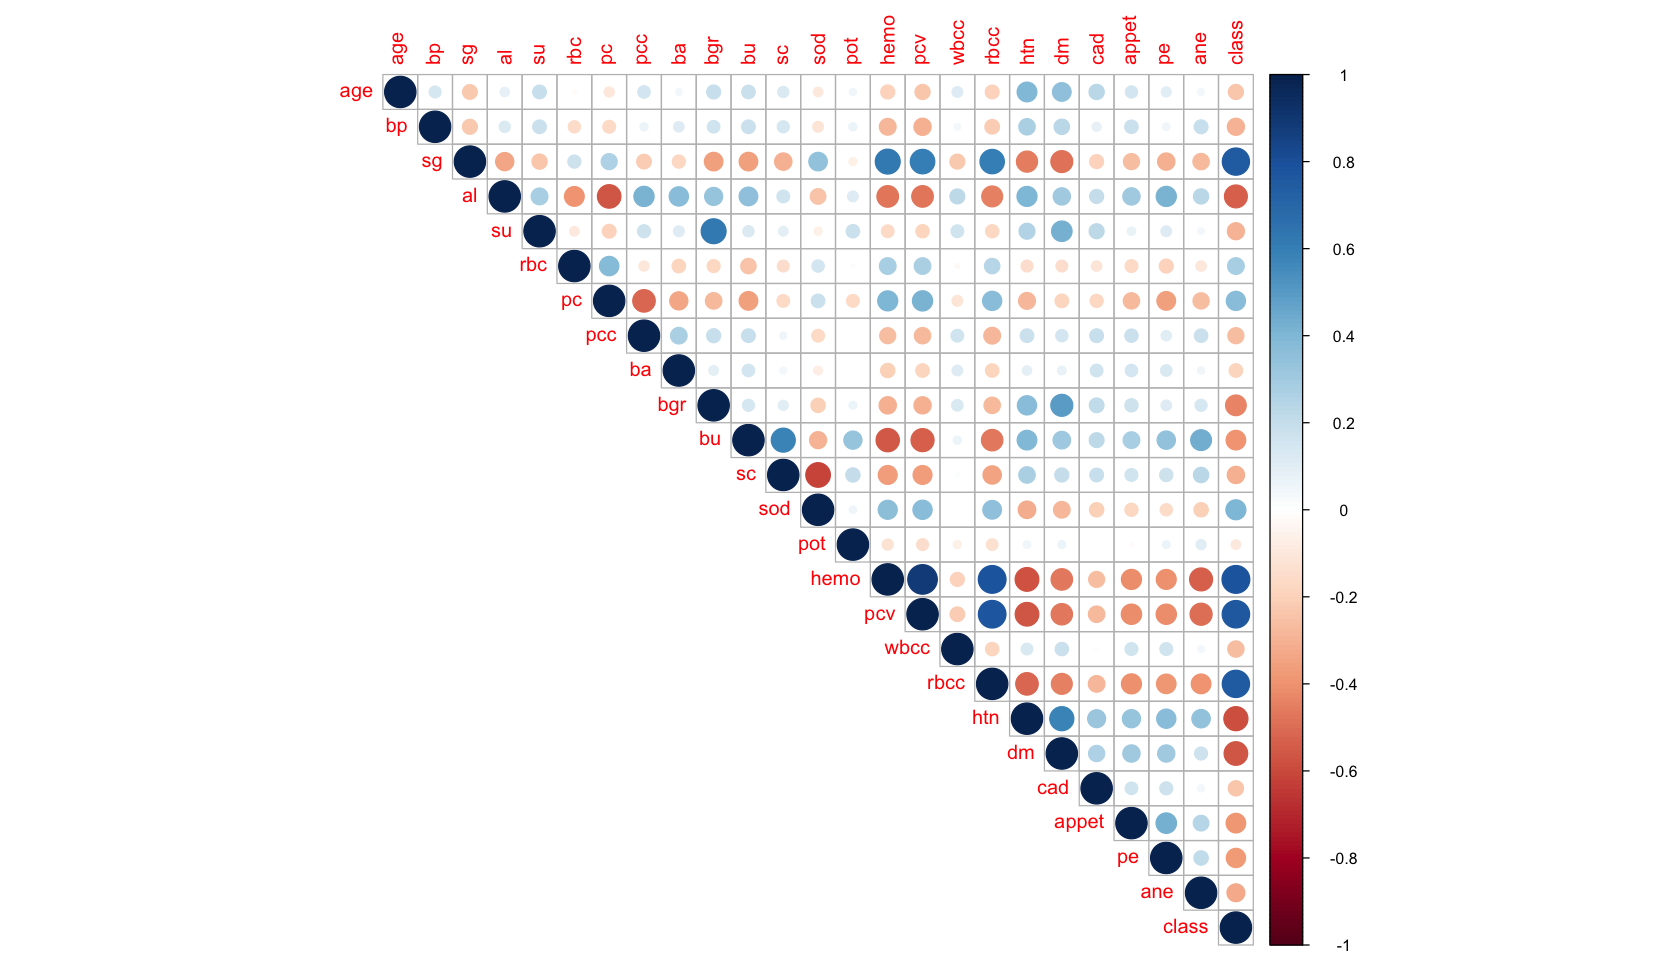

In [12]:
options(repr.plot.width=14, repr.plot.height=8)
M <- cor(ckd_scaled_na_replaced)
corrplot(M, type = "upper")

**Figure 3**: Correlation matrix; size and color of dots indicate the strength and direction of the correlation. All variables are perfectly correlated with themselves.

#### Principal Component Analysis
---
From figures 1, 2, and 3, there appears to be a significant degree of multicollinearity. With this in mind, a principal component analysis (PCA) was applied with 2 principal components to visualize the entire dataset in 2-dimensions. PCA takes an input matrix, the $X$ matrix, where $X$ is our training set without labels and it outputs two matrices $Z$ and $W$. $Z$ contains the 'factor loadings' and $W$ contains the 'factors' or 'principal components'. The matrices $Z$ and $W$ estimate $X$.

$n$ = the number of observations

$d$ = the number of variables

$k$ = the number of 'factors' or principal components.

$$
X \simeq ZW
$$
where, 

$X$ = $n$ x $d$, 

$Z$ = $n$ x $k$

$W$ = $k$ x $d$.

Since we're estimating $X$, the more principal components we specify the more accurately we will be able to estimate $X$. To visualize the dataset in two dimensions, only 2 principal components were required. Unfortunately, the caret package does note return the amount of variance explained by the two principal components.

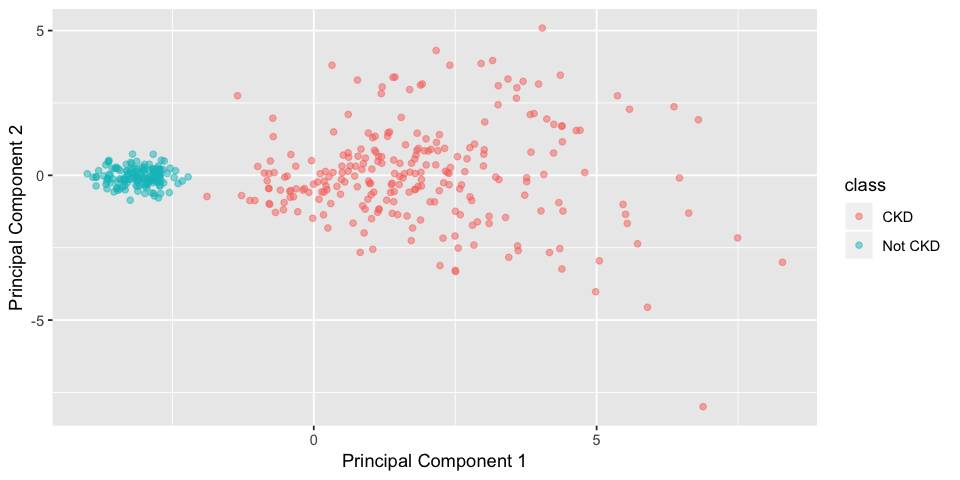

In [13]:
options(repr.plot.width = 8, repr.plot.height = 4)

data <- ckd_scaled_na_replaced %>%
    select(-class) %>%
    select(continuous) %>%
    scale()

cat <- ckd_scaled_na_replaced %>%
    select(categorical_b, categorical_m)

data <- cbind(data, cat)

preProc <- preProcess(data, method = "pca", pcaComp = 2)
components <- predict(preProc, data) %>% 
    cbind(ckd_scaled_na_replaced["class"]) %>%
    mutate(class = as.factor(class))

ggplot(components, aes(x = PC1, y = PC2, color = class)) +
    geom_point(alpha = 0.5) +
    scale_color_discrete(labels = c("1"="CKD","2"="Not CKD")) +
    xlab("Principal Component 1") +
    ylab("Principal Component 2")

**Figure 4**: Plot of PCA; where class 1 is CKD and class 2 is no-CKD. Note the two distinct clusters of data points.


From figure 4, distinct cluters are evident, suggesting it is likely suitable for a classification algorithm like KNN. It may even be possible to use the $Z$ matrix itself to classify accurately (using only two variables), however this would be obscure and difficult to interpret.

### Modelling
Three k-nn classification models were created using different assortments of variables from the same `ckd_scaled_na_replaced_d` dataset, to converge on the most predictive subset of variables. In each case, the dataset was split 70:30 into a training and testing dataset using `caret::createDataPartition`. Models were created using `caret::train` and optimized using 10-fold `caret::trainControl` cross-validation to identify the optimal k. Optimized k values had to be greater than 1, and an odd number for improved robustness and avoidance of ties. Final model results and accuracies are computed using `caret::predict` and reported using `caret::defaultSummary` and `caret::confusionMatrix`.

#### Define Modelling Helper Functions
---
Helper functions to reduce the amount of code repetition.

In [14]:
ckd_scaled_na_replaced_d <- ckd_scaled_na_replaced_d %>%
    mutate(class=as.factor(class))

data_split <- function(var) {
    
    modelling_data <- ckd_scaled_na_replaced_d %>%
        select(var)
    
    training_rows <- modelling_data %>% 
        select(class) %>% 
        unlist() %>% 
        createDataPartition(p=0.7, list=FALSE)

    X_train <- modelling_data %>% 
        select(-class) %>% 
        slice(training_rows) %>% 
        data.frame()
    
    Y_train <- modelling_data %>% 
        select(class) %>%
        slice(training_rows) %>%
        unlist()

    X_test <- modelling_data %>% 
        select(-class) %>% 
        slice(-training_rows) %>% 
        data.frame()
    
    Y_test <- modelling_data %>% 
        select(class) %>% 
        slice(-training_rows) %>% 
        unlist()
    
    return(list(X_train, Y_train, X_test, Y_test))
}

#### All-variables Model
---
The first model makes predictions using all the variables in the dataset. To do this, the full cleaned dataset was split into a training and testing dataset as described above.

In [15]:
set.seed(2019)

var <- c(colnames(ckd_scaled_na_replaced_d))
splits <- data_split(var)
X_train <- splits[1] %>% data.frame()
Y_train <- splits[2] %>% unlist()
X_test <- splits[3] %>% data.frame()
Y_test <- splits[4] %>% unlist()

##### Optimize the number of neighbours
---
The training dataset was used to perform a 10-fold cross-validation. Optimization was performed using up to 50 nearest neighbours. The model converged onto 3 nearest neighbours.

k 
3

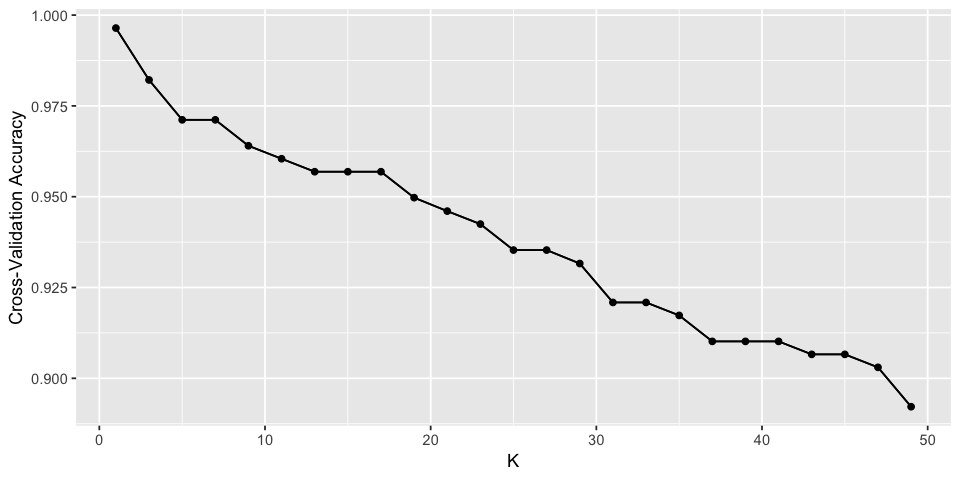

In [16]:
set.seed(2019)

## Run 10-fold cross-validation on the training dataset
train_control <- trainControl(method = 'cv', number = 10)
ks <- data.frame(k = seq(from = 1, to = 50, by = 2))
knn_model <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = ks, trControl = train_control)

# Visualize CV Accuracies
ggplot(knn_model, aes(x = k, y = Accuracy)) +
    geom_line() +
    xlab("K") +
    ylab("Cross-Validation Accuracy")

best_k <- knn_model$results %>%
    filter(k != 1) %>%
    filter(Accuracy == max(Accuracy)) %>%
    select(k) %>%
    filter(k == min(k)) %>%
    unlist()
best_k

**Figure 5**: Cross-validation accuracy of the k-nn model considering all dataset variables. Optimized at k=3.

##### Final Model
---
The final model using all available variables was created using the training dataset, and 3 nearest neighbours (k=3). The final training accuracy was 99.6%.

In [17]:
## Retrain using best k
k <- data.frame(k = best_k)
knn_model_final <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = k)

## What is training accuracy
train_pred <- predict(object = knn_model_final, X_train)
summary <- defaultSummary(data.frame(obs = Y_train, pred = train_pred))
knn_model_accuracy <- summary[[1]]
knn_model_accuracy

[1] 0.9964158

##### Compute the test accuracy
---
The final model was used to predict the classes of observations in the testing dataset. The accruacy of predictions for the final model considering all variables available in the dataset was 96.6%. A confusion matrix was created to visualize the four errors made by the all-variables model.

In [18]:
test_pred <- predict(object = knn_model_final, X_test)
test_summary <- defaultSummary(data.frame(obs = Y_test, pred = test_pred))
knn_model_test_accuracy <- test_summary[[1]]
knn_model_test_accuracy

[1] 0.9661017

In [19]:
confusionMatrix(data = test_pred, reference = Y_test)

Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 70  0
         2  4 44
                                          
               Accuracy : 0.9661          
                 95% CI : (0.9155, 0.9907)
    No Information Rate : 0.6271          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9288          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9459          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9167          
             Prevalence : 0.6271          
         Detection Rate : 0.5932          
   Detection Prevalence : 0.5932          
      Balanced Accuracy : 0.9730          
                                          
       'Positive' Class : 1               
                                          

#### Model Including EDA-selected Variables
---
The results of our EDA were used to perform manual feature selection. As shown in Figure 1, 2, and 3, **Hemoglobin**, **Packed Cell Volume**, **Red Blood Cell Count**, **Diabetes Mellitus**, **Hypertension**, **Albumin**, **Specific Gravity**, appeared most predictive. Using this, the cleaned CKD dataset was further subsetted to include only these variables to train a second k-nn predictive model (EDA-optimized model).

In [20]:
set.seed(2019)

var <- c("hemo","pcv","rbcc","dm","htn", "al_1", "al_4", "al_2", "al_3", "al_0", "al_5", "sg_1.02", "sg_1.01", "sg_1.005", "sg_1.015", "sg_1.025", "class")
splits <- data_split(var)
X_train <- splits[1] %>% data.frame()
Y_train <- splits[2] %>% unlist()
X_test <- splits[3] %>% data.frame()
Y_test <- splits[4] %>% unlist()

##### Optimize the number of neighbours
---
Following the same methodology as above, the optimal k-nearest neighbours was computed by performing 10-fold cross-validation for k ranging from 1 to 50. Cross-validation converged on 3 nearest-neighbours.

k 
3

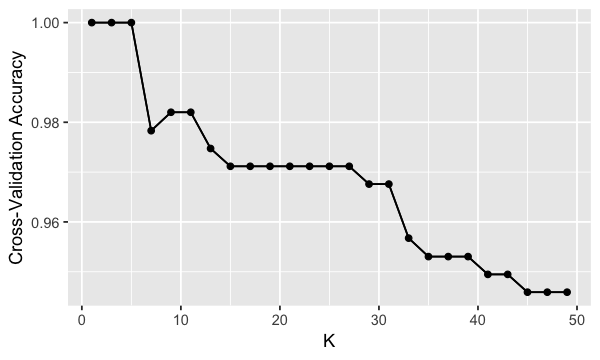

In [21]:
# Set the seed for consistent results
set.seed(2019)

# Set REPR plot width
options(repr.plot.width=5, repr.plot.height=3)

# Run 10-fold cross-validation on the training dataset
train_control <- trainControl(method = 'cv', number = 10)
ks <- data.frame(k = seq(from=1, to=50, by=2))
knn_model <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = ks, trControl = train_control)

# Visualize CV Accuracies
ggplot(knn_model, aes(x = k, y = Accuracy)) +
    geom_line() +
    xlab("K") +
    ylab("Cross-Validation Accuracy")

best_k <- knn_model$results %>%
    filter(k != 1) %>%
    filter(Accuracy == max(Accuracy)) %>%
    select(k) %>%
    filter(k == min(k)) %>%
    unlist()
best_k

**Figure 6**: The cross-validation accuracy of the EDA-optimized model by k. Optimization at k = 3.

###### Final Model
---
The final model was then computed using the optimal k value. For the model containing the EDA-selected variables, the final training accuracy was found to be 100%.

In [22]:
## Retrain using best k
k <- data.frame(k = best_k)
knn_model_final <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = k)

## What is training accuracy
train_pred <- predict(object = knn_model_final, X_train)
summary <- defaultSummary(data.frame(obs = Y_train, pred = train_pred))
knn_model_accuracy <- summary[[1]]
knn_model_accuracy

[1] 1

###### Compute the test accuracy
---
As before, the accuracy of the model was assessed by predicting on the test dataset, and displaying the results in a confusion matrix. In this iteration, the model predicted all variables correctly, and thus had a testing accuracy of 100%. A confusion matrix was created showing 0 incorrectly predicted observations.

In [23]:
test_pred <- predict(object = knn_model_final, X_test)
test_summary <- defaultSummary(data.frame(obs = Y_test, pred = test_pred))
knn_model_test_accuracy <- test_summary[[1]]
knn_model_test_accuracy

[1] 1

In [24]:
confusionMatrix(data = test_pred, reference = Y_test)

Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 74  0
         2  0 44
                                     
               Accuracy : 1          
                 95% CI : (0.9692, 1)
    No Information Rate : 0.6271     
    P-Value [Acc > NIR] : < 2.2e-16  
                                     
                  Kappa : 1          
 Mcnemar's Test P-Value : NA         
                                     
            Sensitivity : 1.0000     
            Specificity : 1.0000     
         Pos Pred Value : 1.0000     
         Neg Pred Value : 1.0000     
             Prevalence : 0.6271     
         Detection Rate : 0.6271     
   Detection Prevalence : 0.6271     
      Balanced Accuracy : 1.0000     
                                     
       'Positive' Class : 1          
                                     

#### Model With Variables from Recursive Feature Elimination
---
The variables chosen to be included into a predictive model can have significant influence over its predictive accuracy. In the final model, the variables included in the k-nn model were chosen using recursive feature elimination as provided by the `caret` package. This function employs a greedy search algorithm to identify the most predictive subset of variables. The results of the feature selection were then plotted.


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy  Kappa AccuracySD KappaSD Selected
         4   0.9791 0.9567    0.03343 0.06795         
         8   0.9931 0.9856    0.01454 0.03034         
        16   0.9966 0.9928    0.01090 0.02276        *
        38   0.9966 0.9928    0.01090 0.02276         

The top 5 variables (out of 16):
   hemo, rbcc, pcv, bgr, sc



[1] "hemo"     "rbcc"     "pcv"      "bgr"      "sc"       "al_0"    
 [7] "sod"      "htn"      "sg_1.015" "dm"       "sg_1.01"  "sg_1.025"
[13] "bu"       "pe"       "bp"       "sg_1.02"

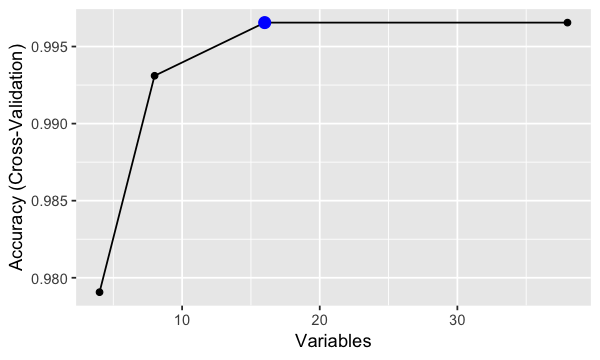

In [25]:
set.seed(2019)
#########################
##   Subset the dataset
########################
var <- c(colnames(ckd_scaled_na_replaced_d))
splits <- data_split(var)
X_train <- splits[1] %>% data.frame()
Y_train <- splits[2] %>% unlist()
X_test <- splits[3] %>% data.frame()
Y_test <- splits[4] %>% unlist()


###########################
##    Perform the RFE
###########################
control <- rfeControl(functions=rfFuncs, method="cv", number=10)

## Run the RFE algorithm
results <- rfe(X_train, Y_train, rfeControl=control)

## Summarize the results
print(results)

## List the chosen features
predictors(results)

## Plot the results
ggplot(results)

**Figure 7**: Cross-validation accuracy by the number of variables included. Peak performance is reached at 16 variables.

#### Conclusions
---
Recursive feature elimination on all variables in the dataset converges on the following 16 variables as being the most predictive: **Hemoglobin**, **Red Blood Cell Count**, **Packed Cell Volume**, **Blood Glucose Random**, **Serum Creatinine**, **Sodium**, **Specific Gravity 1.015**, **Albumin 0**, **Hypertension**, **Diabetes mellitus**, **Specific Gravity 1.01**, **Specific Gravity 1.025**, **Sugar 0**, **Blood Urea**, **Blood Pressure**, **Pedal Edema**. This subset of variables includes all of those that were identified in the EDA.

#### Using Above Results: Create the training sets
---
The complete dataset was subsetted to include only the variables that the RFE selected for, and used to create training and testing datasets, using the same method as above.

In [26]:
set.seed(2019)

var <- predictors(results) %>% unlist()  %>% append('class')
splits <- data_split(var)
X_train <- splits[1] %>% data.frame()
Y_train <- splits[2] %>% unlist()
X_test <- splits[3] %>% data.frame()
Y_test <- splits[4] %>% unlist()

##### Optimize the number of neighbours
---
The optimal k value for the third model was selected as above, using cross-validation.

k 
3

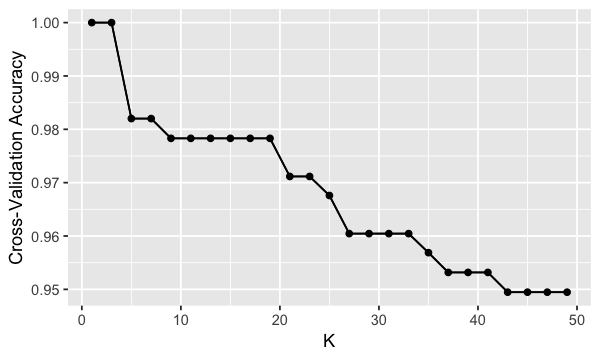

In [27]:
set.seed(2019)

## Run 10-fold cross-validation on the training dataset
train_control <- trainControl(method = 'cv', number = 10)
ks <- data.frame(k = seq(from = 1, to = 50, by=2))
knn_model <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = ks, trControl = train_control)

## Visualize CV Accuracies
ggplot(knn_model, aes(x = k, y = Accuracy)) +
    geom_line() +
    xlab("K") +
    ylab("Cross-Validation Accuracy")

best_k <- knn_model$results %>%
    filter(k != 1) %>%
    filter(Accuracy == max(Accuracy)) %>%
    select(k) %>%
    filter(k == min(k)) %>%
    unlist()
best_k

**Figure 8**: Cross-validation accuracy of the RFE-model by k. Optimization at k=3.

#### Final Model
---
Following the same methods as above, the optimized k was used to train a final k-nn model and compute the training accuracy. The final training accuracy was 100%.

In [28]:
## Retrain using best k
k <- data.frame(k = best_k)
knn_model_final <- train(x = X_train, y = Y_train, method = 'knn', tuneGrid = k)

## What is training accuracy
train_pred <- predict(object = knn_model_final, X_train)
summary <- defaultSummary(data.frame(obs = Y_train, pred = train_pred))
knn_model_accuracy <- summary[[1]]
knn_model_accuracy

[1] 1

#### Compute Test Accuracy
---
The final model was used to compute the test accuracy. The final test accuracy was 99%.

In [29]:
test_pred <- predict(object = knn_model_final, X_test)
test_summary <- defaultSummary(data.frame(obs = Y_test, pred = test_pred))
knn_model_test_accuracy <- test_summary[[1]]
knn_model_test_accuracy

[1] 0.9915254

In [30]:
confusionMatrix(data = test_pred, reference = Y_test)

Confusion Matrix and Statistics

          Reference
Prediction  1  2
         1 73  0
         2  1 44
                                          
               Accuracy : 0.9915          
                 95% CI : (0.9537, 0.9998)
    No Information Rate : 0.6271          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.982           
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9865          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9778          
             Prevalence : 0.6271          
         Detection Rate : 0.6186          
   Detection Prevalence : 0.6186          
      Balanced Accuracy : 0.9932          
                                          
       'Positive' Class : 1               
                                          

Measure | All Variables Model | EDA-Optimized Model | RFE-Optimized Model
--- | --- | --- | ---
Variables Included | 38 | 16 | 16
Training Accuracy | 99.6% | 100% | 100%
Testing Accuracy | 96.6% | 100% | 99.2%
Incorrectly Classified | 4 | 0 | 1

**Table 7**: Summary of three models created

## Discussion
As a condition linked to many underlying health problems (Levey et al. 2003), Chronic Kidney Disease is likely to be ideal for diagnosis by the k-nearest neighbours (k-nn) classification algorithm. From the start, an initial exploratory data analysis (EDA) revealed many variables with dimorphic distributions with respect to disease class (Figure 1, 2). CKD and not-CKD subgroups had visually distinct distributions for hemoglobin, packed cell volume, and red blood cell count (Figure 1). Similarly, each disease class subgroup showed distinct distribution of observations across each of the nominal levels of Diabetes mellitus, hypertension, albumin, and specific gravity (Figure 2). A correlation matrix corroborated these findings, suggesting that these particular variables correlated strongly with disease class and thus are likely to have strong predictive power (Figure 3). Such a finding provides a strong argument supporting the decision to use the k-nn algorithm for disease classification. Further support for the appropriateness of k-nn classification, was given by the principal component analysis performed (PCA; Figure 4). This statistical method compresses a multidimensional dataset into two variables, making visualization possible. A quick glance at Figure 4 reveals striking separation between disease class in the PCA variables, suggesting that there is a distinct and significant separation in the observations between disease classes. 

Each of the three k-nn models created using the UCL ML CKD dataset performed surprisingly well, the results of which are summarized in Table 7. As expected, the first model containing all the variables in the dataset had the poorest testing accuracy, misclassifying four of the observations in the datasets (~4% of observations). However, subsetting the dataset to include only the variables determined to be predictive in the EDA (EDA-optimized model) pushed the testing accuracy to 100%. This change illustrates the importance of identifying which variables are predictive before training the model. Variables that are not truly predictive – that is, they do not consistently differ between classes – simply introduce noise into the model. That is likely what happened in this case; the EDA allowed us to parse out the noise in the dataset, and provide the model with only the variables that change meaningfully between classes.

Even more interesting was the differences between the EDA-optimized model and the third (RFE-optimized) model. In the third model, a recursive version of feature elimination was used to determine the subset of variables that were most predictive. These variables aligned quite closely with those of the EDA, but not precisely. Notable differences include the selection of blood urea, blood pressure, and pedal edema, all of which are biologically sensible (Level et al. 2003). Additionally, feature elimination converged upon keeping the minimal number of levels of nominal variables necessary to distinguish between classes. For example, CKD negative observations only ever had an albumin level of 0; feature elimination only included the dummy variable corresponding to the zeroth albumin level. Despite these optimizations, the RFE-optimized model made one mistake during classification of the test dataset, whereas the EDA-optimized model predicted everything perfectly. Interestingly enough however, looking at Figure 4, there is one single point that aligns closely with the CKD negative subgroup, but is classified as CKD positive. It is entirely possible that this is a classification error. If so, it would actually be the RFE-optimized model that is most accurate which is what was expected at the begnining of the study. 

Unfortunately, however, the exciting results of a “perfect” classification model is also its own concern. Rarely do classification models have 100% accuracy; it would be expected that they would make a few mistakes. With this dataset however, the model was near perfect without any feature selection at all. This may indicate that the dataset is too perfect – that the variables are unnaturally differentiated. The performance of the models created in this study may be significantly lower when subjected to an entirely different dataset. Further testing is therefore essential, to verify whether or not this is the case. 

The goal of this study was to determine if common laboratory measurements can be used to predict diagnosis, and if so what variables are most predictive. The results of this study suggest that this is certainly possible. Hemoglobin, packed cell volume, red blood cell count, diabetes status, the presence of hypertension, albumin levels, and blood serum specific gravity all had strong predictive power, being selected both manually and algorithmically, and produced near-perfect results when used to train a k-nn classification model. As described however, there is a risk that this dataset is too perfect, and may be giving false impressions regarding the accuracy of these models. Nonetheless, this study demonstrates a promising classification model that could be used to expedite patient CKD diagnoses, affording patients quicker access to the care that they may need. By doing so, nephrology workflow efficiency would increase, financial burdens minimized, and ultimately leading to an improvement in patient prognosis overall. 


## References
---
Levey A.S, et al. 2003. National Kidney Foundation Practice Guidelines for Chronic Kidney Disease: Evaluation, Classification, and Stratification. Annals of Internal Medicine, 139(2): 137-149.

Levey A.S, et al. 2007. Prevalence of Chronic Kidney Disease in the United States. Journal of the American Medical Association, 298(17): 2038-2047.